# Linking Writing Processes to Writing Quality

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np

#### load the training logs and scores

In [2]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
print(train_logs.shape)
train_logs.head()

(8405898, 11)


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [3]:
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
print(train_scores.shape)
train_scores.head()

(2471, 2)


,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


##### check the information about the training logs and scores

In [4]:
# info on train logs
train_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


In [5]:
# info on train scores
train_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


##### check for missing values

In [6]:
# check for missing values in the train logs
train_logs.isnull().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

In [7]:
# check for missing values in the train scores
train_scores.isnull().sum()

id       0
score    0
dtype: int64

#### Data Preprocessing and Feature Engineering

In [8]:
# aggregating features for each essay based on the log data
log_features = train_logs.groupby('id').agg({
    'action_time': ['sum', 'mean'],  # total and average action time
    'word_count': 'last',            # final word count
}).reset_index()

In [9]:
# Assuming log_features has a multi-level index, reset it to make it single-level
log_features = log_features.reset_index()

In [10]:
# Flatten the columns of log_features by dropping the empty level in the MultiIndex
log_features.columns = log_features.columns.droplevel(1)

# Check the column names of both DataFrames
print("Column names of log_features:", log_features.columns)
print("Column names of train_scores:", train_scores.columns)

Column names of log_features: Index(['index', 'id', 'action_time', 'action_time', 'word_count'], dtype='object')
Column names of train_scores: Index(['id', 'score'], dtype='object')


In [11]:
# merge log features with scores based on essay ID
merged_data = pd.merge(log_features, train_scores, on='id', how='inner')

In [12]:
# check out the merged data
merged_data.head()

,index,id,action_time,action_time,word_count,score
0,0,001519c8,297243,116.246774,255,3.5
1,1,0022f953,275391,112.221271,320,3.5
2,2,0042269b,421201,101.837766,404,6.0
3,3,0059420b,189596,121.848329,206,2.0
4,4,0075873a,313702,123.943896,252,4.0


##### checking for correlation

In [13]:
# Select only the numerical columns for correlation analysis
numerical_columns = merged_data.select_dtypes(include=[np.number])

In [14]:
# calculate the correlation matrix
correlation_matrix = numerical_columns.corr()
correlation_threshold = 0.5

In [15]:
# Find highly correlated features
highly_correlated_features = correlation_matrix[((correlation_matrix > correlation_threshold) | (correlation_matrix < -correlation_threshold)) & (correlation_matrix != 1)]

# Drop one of the duplicated columns to avoid the error
highly_correlated_features = highly_correlated_features.loc[~highly_correlated_features.index.duplicated(keep='first')]

# Rename columns with a prefix to make them unique
highly_correlated_features = highly_correlated_features.add_prefix('feature_').unstack().dropna().reset_index()

# Print the highly correlated features
print("Highly Correlated Features:")
for index, row in highly_correlated_features.iterrows():
    feature1 = row['level_0']
    feature2 = row['level_1']
    correlation = row[0]
    print(f"{feature1} - {feature2}: {correlation:.2f}")

Highly Correlated Features:
feature_action_time - word_count: 0.73
feature_action_time - score: 0.55
feature_word_count - action_time: 0.73
feature_word_count - score: 0.64
feature_score - action_time: 0.55
feature_score - word_count: 0.64


In [16]:
# Find highly correlated features with scores
highly_correlated_features = np.abs(correlation_matrix['score']).sort_values(ascending=False)
highly_correlated_features = highly_correlated_features[highly_correlated_features > correlation_threshold]

# Print the highly correlated features
print("Highly Correlated Features with Scores: ")
for feature, correlation in highly_correlated_features.items():
    print(f"{feature}: {correlation:.2f}")

Highly Correlated Features with Scores: 
score: 1.00
word_count: 0.64
action_time: 0.55


In [17]:
# visualising correlation
# importing libraries to aid visualisation
import seaborn as sns
import matplotlib.pyplot as plt

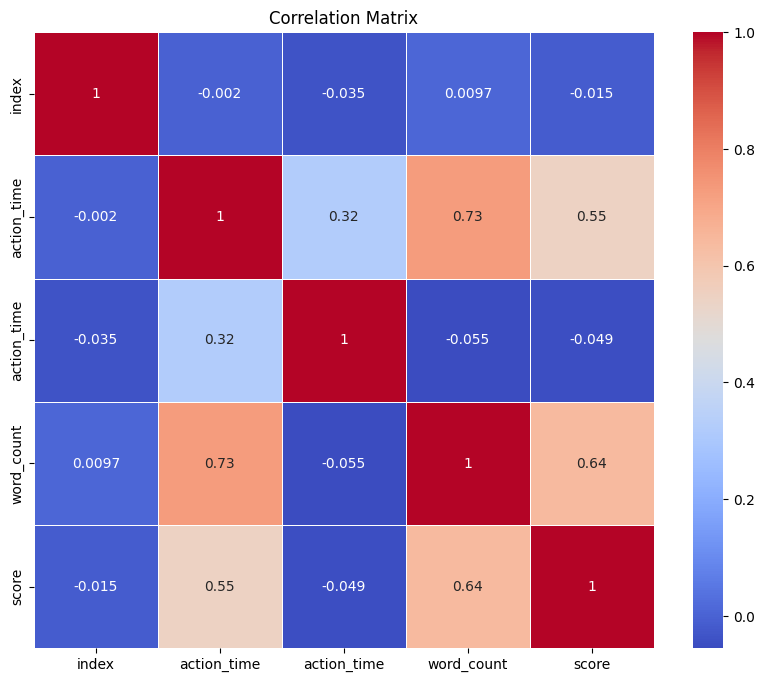

In [18]:
# visual correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

#### Prediction Analysis

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# split the data into training and validation sets
X = merged_data.drop(columns=['id', 'score'])
y = merged_data['score']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                   random_state = 42)

In [21]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_test)

In [22]:
# Hyperparameter Tuning
param_grid = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

In [23]:
# Get the best model from hyperparameter tuning
best_model = grid_search.best_estimator_

In [24]:
# Make predictions on the validation set
y_pred = best_model.predict(X_valid_scaled)

In [25]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [26]:
print(f"Mean Squared Error: {mse: .2f}\n"
     f"Root Mean Squared Error: {rmse: .2f}\n"
     f"R-squared: {r2: .2f}")

Mean Squared Error:  0.49
Root Mean Squared Error:  0.70
R-squared:  0.50


###### observations:

In this context, an MSE of 0.49 suggests that, on average, the model's predictions are off by about 0.49 units squared from the actual scores. Lower MSE values indicate better model performance.

An RMSE of 0.70 means that, on average, the model's predictions are off by approximately 0.70 units from the actual scores. Like MSE, lower RMSE values indicate better model performance.

 R-squared values range from 0 to 1, with higher values indicating better model fit. An R² of 0.50 is moderate, suggesting that the model has some predictive power but may benefit from further improvement.

###### summary

In summary, the linear regression model has a moderate level of predictive power after hyperparameter tunning, as indicated by the R-squared value of 0.50. The MSE and RMSE values provide additional insights into the accuracy of your predictions, with lower values indicating better performance.

In [27]:
# no visualizations yet

In [28]:
# visualisation to check for overfitting / underfitting

In [29]:
from sklearn.model_selection import learning_curve

In [30]:
import warnings
warnings.filterwarnings('ignore')

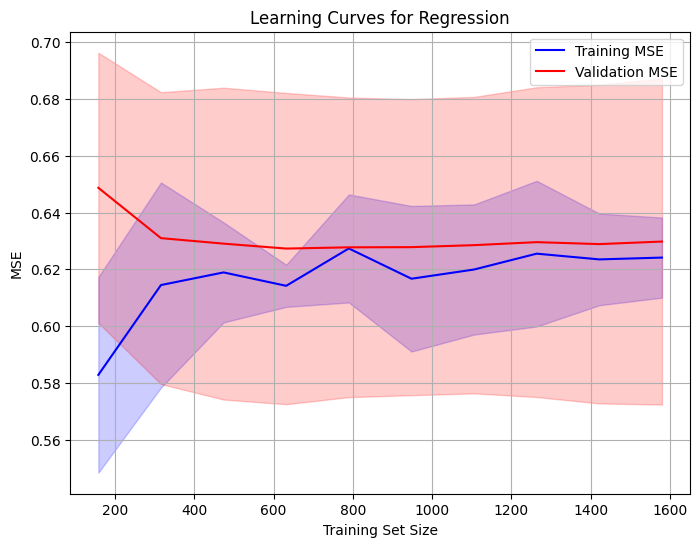

In [31]:
# Define a function to calculate mean squared error (MSE) for regression
def neg_mse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    return -mse  # Negate MSE since GridSearchCV minimizes by default

# Plot the learning curves for the best model
plt.figure(figsize=(8, 6))
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train_scaled,  # Use your scaled training data here
    y=y_train,          # Your training labels here
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=neg_mse_scorer,  # Use the custom MSE scorer
    shuffle=True,
    random_state=42
)

# Calculate the mean and standard deviation of train and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)  # Negate since we used neg_mse_scorer
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curves with the mean and standard deviation
plt.plot(train_sizes, train_scores_mean, label='Training MSE', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', color='red')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves for Regression')
plt.legend()
plt.grid(True)
plt.show()

It's fairly balanced! Linear Regression isn't suitable enough